# Code Review #2 - Stock Data EDA

In [3]:
from pathlib import Path
import numpy as np
import pandas as pd
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

idx = pd.IndexSlice
sns.set_style('whitegrid')

results_path = Path('KR2_results', 'asset_pricing')
if not results_path.exists():
    results_path.mkdir(parents=True)

## 1. 데이터 불러오기

### Prices, Metadata

In [4]:
prices = pd.read_hdf(results_path / 'data.h5', 'stocks/prices/adjusted')
metadata = pd.read_hdf(results_path / 'data.h5', 'stocks/info').rename(columns=str.lower)

In [5]:
metadata.head(5)

,address1,address2,city,zip,country,phone,fax,website,industry,sector,...,freecashflow,operatingcashflow,earningsgrowth,revenuegrowth,grossmargins,ebitdamargins,operatingmargins,financialcurrency,trailingpegratio,openinterest
005930.KS,129 Samsung-Ro,Maetan-3dong Yeongtong-gu,Suwon-si,443-742,South Korea,82 2 2255 0114,82 3 1200 7538,https://www.samsung.com,Consumer Electronics,Technology,...,-1.345999e+13,5.205390e+13,-0.859,-0.223,0.31972,0.19889,0.06076,KRW,NaN,NaN
373220.KS,"108, Yeoui-daero",Yeongdeungpo-Gu,Seoul,07335,South Korea,82 2 3777 1114,NaN,https://www.lgensol.com,Specialty Industrial Machinery,Industrials,...,-6.875540e+12,1.267587e+12,3.593,0.730,0.15789,0.10627,0.04871,KRW,NaN,NaN
000660.KS,2091 Gyeongchung-daero,Bubal-eup,Icheon-Si,NaN,South Korea,82 31 5185 4114,NaN,https://www.skhynix.com,Semiconductors,Technology,...,-8.570626e+12,4.371575e+12,NaN,-0.471,0.03433,0.23260,-0.21051,KRW,0.621,NaN
207940.KS,"300, Songdo Bio-daero",Yeonsu-gu,Incheon,21987,South Korea,82 3 2455 3114,NaN,https://samsungbiologics.com,Biotechnology,Healthcare,...,-5.206233e+11,1.297787e+12,0.207,0.330,0.49948,0.42886,0.31606,KRW,NaN,0.0
005490.KS,"6261, Donghaean-ro",Nam-gu,Pohang,NaN,South Korea,NaN,NaN,https://www.posco.com,Steel,Basic Materials,...,3.865827e+11,8.028374e+12,-0.530,-0.126,0.06718,0.07870,0.03133,KRW,NaN,NaN


### Select tickers with metadata

In [6]:
sectors = (metadata.sector.value_counts() >= 9).index
tickers_with_errors = []
tickers_with_metadata = metadata[
    metadata.sector.isin(sectors)
    & metadata.marketcap.notnull()
    & metadata.sharesoutstanding.notnull()
    & (metadata.sharesoutstanding > 0)
].index.drop(tickers_with_errors)
metadata = metadata.loc[
    tickers_with_metadata, ["sector", "sharesoutstanding", "marketcap"]
]
metadata.index.name = "ticker"

- 메타데이터에서 9회 이상 카운트된 섹터만 선택합니다.
- 메타데이터의 오류를 검정합니다. 아래의 경우는 `drop`합니다.
    + 섹터가 없는 경우
    + 시가총액이 없는 경우
    + 발행주식수가 없는 경우
    + 발행주식수가 0인 경우
- 메타데이터를 다시 수정합니다.

In [7]:
# Check if 'tickers_with_metadata' contains valid tickers in 'prices' DataFrame
valid_tickers = set(prices.index.get_level_values("ticker"))
tickers_with_metadata = [
    ticker for ticker in tickers_with_metadata if ticker in valid_tickers
]

# Use .loc to select rows based on the tickers_with_metadata list
prices = prices.loc[pd.IndexSlice[tickers_with_metadata, :], :] # type: ignore

가격 데이터도 수정된 메타데이터를 이용하여 다시 슬라이싱을 통해 수정합니다.

In [8]:
close = prices.close.unstack("ticker").sort_index()
volume = prices.volume.unstack("ticker").sort_index()

returns = (
    prices.close.unstack("ticker")
    .resample("W-FRI")
    .last()
    .sort_index()
    .pct_change()
    .iloc[1:]
)

with pd.HDFStore(results_path / "autoencoder.h5") as store:
    store.put("close", close)
    store.put("volume", volume)
    store.put("returns", returns)
    store.put("metadata", metadata)

수정된 가격 데이터를 이용하여 `close`와 `volume`을 정의합니다. `return` 데이터는 `close`를 이용하여 주간 수익률로 정의합니다. 이러한 데이터를 `autoencoder.h5`에 저장하면서 이후 모델에 사용할 수 있도록 합니다.

<Axes: xlabel='date', ylabel='ticker'>

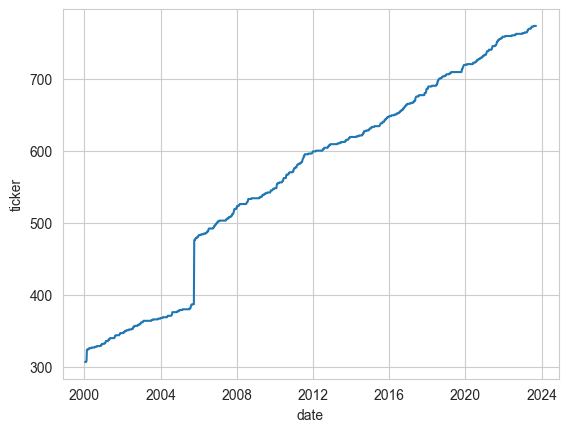

In [38]:
data_ = pd.DataFrame(returns.count(1), columns=['ticker'])
sns.lineplot(data=data_, x="date", y="ticker")

`return`이 NaN이 아닌 Ticker 개수를 날짜를 기준으로 데이터를 시각화했습니다. 특정 시점에 주식 종목 수가 Discrete하게 증가하는 것을 확인할 수 있습니다. 사후 검증 결과 yfinance 데이터의 문제로 확인되었습니다. 해당 시점에 KOSPI 시장에서에 어떤 이벤트가 있을 것으로 예상했지만 다른 라이브러리로 확인한 결과 해당 시점에는 이벤트가 없었습니다. 해당 오류를 배제하기 위해서는 해당 시점의 데이터를 사용하지 않거나 다른 라이브러리를 사용하여 데이터를 불러와야 합니다. 그러나 yfinacne처럼 편하게 메타데이터를 받을 수 있는 라이브러리를 아직 찾지 못했습니다. 또한, 해당 시점을 추가하더라도 모델에 큰 영향을 주지 않는 것으로 확인되었습니다. 이러한 이슈가 있었다는 것을 참고차 언급하고 넘어가겠습니다.

## Factor Engineering

In [10]:
MONTH = 21

한 달은 주 거래일 기준으로 21일로 정의합니다.

<table><tr>
<td> <p align="center"><img src="../images/Firm_Characteristics.png"/></p> </td>
<td> <p align="center"><img src="../images/Firm_Characteristics_2.png"/></p> </td>
</tr></table>

팩터 엔지니어링은 위 그림과 같이 진행합니다. 크게 4개의 특성으로 분류할 수 있습니다. `Price Trend`, `Liquidity Metrics`, `Risk Measures`, `Meta Data`입니다.

`Price Trend`는 가격의 변동성을 봅니다. 예를 들어 `Momentum`(모멘텀)이나 `Reversal`(리버설) 전략 등이 있습니다. 간단하게 모멘텀은 '오르는 주식은 계속 오르고, 내리는 주식은 계속 내릴 것이다.'라는 것이고, 리버설은 '오르는 주식은 내릴 것이고, 내리는 주식은 오를 것이다.'로 요약할 수 있습니다. 또 산업군 별로 주식들을 그룹을 지어 산업군 내의 모멘텀을 보기도 합니다.

`Liquidity Metrics`는 `Turnover`(매매 회전율), `Turnover Volatility`(매매 회전율의 변동성)과 같은 시장 유동성 지표를 의미합니다. `Amihud Illiquidity`는 거래량 대비 일일 절대 수익률 비율을 뜻하는 Metric입니다.

`Risk Measures`는 주식의 리스크를 측정하는 지표입니다. 수익률의 변동성이 커지면 해당 시장에 어떠한 리스크가 존재한다는 것이고, `Beta`는 주식의 시장 대비 상대적인 변동성을 의미합니다. `idiosysncratic return volatility`(특이 수익률의 변동성)이 커지면 설명할 수 없거나 예상할 수 없는 큰 수익률이 높아진 것이므로 해당 시장의 위험이 커졌다고 볼 수 있습니다.

`Meta Data`는 `Return`으로 여러 팩터들을 이용하여 우리가 예측해야 할 종속 변수에 해당합니다. 이제 코드를 살펴보겠습니다.

### Price Trend

#### Short-Term Reversal

In [11]:
# 1-month cumulative return
mom1m = close.pct_change(periods=MONTH).resample("W-FRI").last().stack().to_frame("mom1m")  # type: ignore
mom1m.squeeze().to_hdf(results_path / "autoencoder.h5", "factor/mom1m")

[Short-Term Reversal](https://quantpedia.com/strategies/short-term-reversal-in-stocks)입니다. 1개월 수익률을 계산합니다. 링크를 눌러 해당 전략에 대한 자세한 설명을 참고하세요.

`Short-Term Reversal`은 극단적인 상승 또는 하락 움직임 이후 단기적으로 반전하는 자산의 경향을 활용하는 금융 트레이딩 접근법입니다. 이 전략은 단기간에 큰 폭의 상승 또는 하락을 경험한 종목을 찾아내어 단기적으로 평균 또는 평균 수익률로 되돌아갈 것으로 예상하는 것입니다. 이 전략을 사용하는 트레이더는 일반적으로 최근 상승한 종목을 매도하고 최근 하락한 종목을 매수하여 반전을 기대합니다. 이는 행동주의 금융에 뿌리를 두고 있으며, 이러한 단기 추세를 시장의 과민 반응과 그에 따른 조정으로 보고 수익 기회를 제공합니다. 그러나 이 전략은 위험할 수 있고 타이밍과 시장 상황에 따라 크게 달라질 수 있으므로 투자자는 위험 관리 기법을 사용하는 것이 필수적입니다.

#### Stock Momentum

In [12]:
# 11-month cumulative returns ending 1-month before month end
mom12m = (
    close.pct_change(periods=11 * MONTH)
    .shift(MONTH)
    .resample("W-FRI")
    .last()
    .stack()
    .to_frame("mom12m")
)  # type: ignore
mom12m.to_hdf(results_path / 'autoencoder.h5', 'factor/mom12m')

[Stock Momentum](https://quantpedia.com/strategies/momentum-factor-effect-in-stocks/)입니다. 최근 1개월 수익률을 제외하고 12개월의 누적 수익률을 계산합니다. 링크를 눌러 해당 전략에 대한 자세한 설명을 참고하세요.

`Stock Momentum`은 주식의 가격 움직임에 기반을 둔 것으로, 특정 주식이 최근에 강한 상승 또는 하락 추세를 보이면 이러한 추세가 지속될 것이라는 기대에 따라 투자 결정을 내리는 방법입니다. 위 설명에서 언급된 "최근 1개월 수익률을 제외하고 12개월의 누적 수익률을 계산"하는 방법은, 최근 한 달 동안의 주식의 수익률을 무시하고 그 이전 12개월 동안의 수익률을 기반으로 주식의 모멘텀을 평가하는 방법입니다. 이러한 접근 방식은 최근의 장기적인 가격 추세를 파악하고, 단기적인 변동성이나 노이즈를 배제하여 더욱 정확한 투자 결정을 돕기 위함입니다. 이러한 모멘텀 전략은 주로 중기적인 시각에서 주식을 보유하는 투자자들에게 인기가 있으며, 적절한 리스크 관리와 함께 사용될 때 높은 수익을 가져올 수 있는 잠재력이 있습니다.

#### Momentum Change

In [13]:
# Cumulative return from months t-6 to t-1 minus months t-12 to t-7.
chmom = (close
         .pct_change(periods=6 * MONTH)
         .sub(close.pct_change(periods=6 * MONTH).shift(6 * MONTH))
         .resample('W-FRI')
         .last()
         .stack()
         .to_frame('chmom')) # type: ignore
chmom.to_hdf(results_path / 'autoencoder.h5', 'factor/chmom')

`Momentum Change`은 주식의 가격 변동성과 기존의 모멘텀을 결합하여 중간기간의 주식 가격의 변화를 측정하는 방법입니다. 이 전략은 `Cumulative return from months t-6 to t-1 minus months t-12 to t-7`을 사용하여 주식의 모멘텀의 변화를 측정합니다. 이 계산을 통해 최근의 가격 변화가 지난 몇 개월 동안의 추세에 비해 어떻게 변화하고 있는지를 파악하게 됩니다.

예를 들어, 최근 6개월 동안의 누적 수익률이 높고 그 이전의 6개월 동안의 누적 수익률이 낮을 경우, 이는 주식의 모멘텀이 증가하고 있다는 신호로 해석될 수 있습니다. 반대로, 최근 6개월 동안의 누적 수익률이 낮고 그 이전의 6개월 동안의 누적 수익률이 높을 경우, 이는 모멘텀이 감소하고 있다는 신호로 해석될 수 있습니다. 이러한 정보를 바탕으로 투자자는 주식을 매수 또는 매도하는 결정을 내릴 수 있으며, 이런 방식으로 모멘텀의 변화를 활용하여 투자 기회를 포착할 수 있습니다.

#### Industry Momentum

In [ ]:
# Equal-weighted avg. industry 12-month returns
indmom = (close.pct_change(12*MONTH)
          .resample('W-FRI')
          .last()
          .stack()
          .to_frame('close') # type: ignore
          .join(metadata[['sector']]).groupby(['date', 'sector'])
          .close.mean()
          .to_frame('indmom')
          .reset_index())
indmom = (returns
          .stack()
          .to_frame('ret') # type: ignore
          .join(metadata[['sector']])
          .reset_index()
          .merge(indmom)
          .set_index(['date', 'ticker'])
          .loc[:, ['indmom']])
indmom.to_hdf(results_path / 'autoencoder.h5', 'factor/indmom')

`Industry Momentum`은 주식의 모멘텀을 측정하는 방법 중 하나로, 특정 산업 부문 내의 주식들의 수익률을 바탕으로 그 산업의 전반적인 모멘텀을 평가합니다. 위의 코드 예제에서는 12개월 동안의 주식의 수익률을 계산하여 주간 빈도로 리샘플링하고, 각 산업 부문별로 이를 그룹화하여 평균 수익률을 계산하는 과정을 보여줍니다.

구체적으로 설명하면, 먼저 `close.pct_change(12*MONTH)`을 사용하여 최근 12개월간의 주식의 월별 수익률을 계산합니다. `.resample('W-FRI').last()`를 사용하여 이 데이터를 주간 빈도로 리샘플링하고, 각 주의 마지막 영업일의 데이터를 가져옵니다. 그런 다음 ``.stack()`을 사용하여 데이터를 재구조화하고, `.to_frame('close')`를 사용하여 데이터 프레임을 생성합니다.

산업 정보가 포함된 메타데이터와 이 데이터 프레임을 조인한 후, `.groupby(['date', 'sector']).close.mean()`을 사용하여 각 날짜와 산업 부문별로 평균 수익률을 계산합니다. 이렇게 계산된 산업 모멘텀 데이터는 주식의 수익률 데이터와 함께 사용되어, 특정 주식의 모멘텀이 그 주식이 속한 산업 부문의 전반적인 모멘텀과 어떻게 관련되어 있는지를 분석하는 데 사용될 수 있습니다.

이러한 `Industry Momentum`은 특정 산업 부문의 전반적인 트렌드를 파악하고, 이를 바탕으로 투자 결정을 내리는 데 유용할 수 있습니다.

#### Recent Max Return

In [ ]:
# Max daily returns from calendar month t-1
maxret = (close
           .pct_change(periods=MONTH)
           .rolling(21)
           .max()
           .resample('W-FRI')
           .last()
           .stack()
           .to_frame('maxret')) # type: ignore
maxret.to_hdf(results_path / 'autoencoder.h5', 'factor/maxret')

`Recent Max Return`은 과거 한 달 동안의 일일 최대 수익률을 계산하여 주식의 투자 가치를 평가하는 방법입니다.

코드를 따라가보면, `close.pct_change(periods=MONTH)`을 사용하여 일일 수익률을 계산합니다. 그런 다음, `.rolling(21).max()`를 사용하여 이 수익률의 21일 롤링 윈도우 내에서 최대값을 찾습니다. 이는 과거 한 달 동안의 최대 일일 수익률을 식별하는 데 도움이 됩니다. `.resample('W-FRI').last()`는 데이터를 주간 빈도로 리샘플링하고 각 주의 마지막 데이터를 가져옵니다. `.stack().to_frame('maxret')`는 이 데이터를 재구조화하고 데이터 프레임을 생성합니다.

이러한 최대 일일 수익률 데이터는 주식의 변동성과 리스크를 평가하는 데 사용될 수 있습니다. 높은 최대 일일 수익률은 주식의 높은 변동성을 나타낼 수 있으며, 이러한 정보는 투자자가 리스크 톨러런스와 투자 전략에 맞게 포트폴리오를 구성하는 데 도움이 될 수 있습니다.

#### Long-Term Reversal

In [ ]:
# Cumulative returns months t-36 to t-13.
mom36m = (close
           .pct_change(periods=24*MONTH)
           .shift(12*MONTH)
           .resample('W-FRI')
           .last()
           .stack()
           .to_frame('mom36m')) # type: ignore
mom36m.to_hdf(results_path / 'autoencoder.h5', 'factor/mom36m')

`Long-Term Reversal`은 자산 가격이 장기적으로 과대평가 또는 과소평가된 후에 이전의 평균 가격으로 회귀하는 경향을 바탕으로 합니다. 이 전략에서 `Cumulative returns months t-36 to t-13`은 과거 36개월부터 13개월 전까지의 누적 수익률을 의미합니다. 이러한 수익률의 데이터를 분석하여 과거에 과대평가되었던 자산이 시간이 지남에 따라 가치를 잃거나, 과소평가되었던 자산이 가치를 회복하는 경향을 찾아내려고 합니다.

`Long-Term Reversal`은 주로 행동 금융학에 기반을 두고 있으며, 투자자의 과잉 반응이나 심리적 편향이 시장에서 가격 왜곡을 일으키는 원인이라고 보는 견해를 반영합니다. 이런 가격 왜곡은 시간이 지남에 따라 교정되며, 이 과정에서 투자 기회가 발생합니다. 따라서 `Long-Term Reversal` 전략을 사용하는 투자자는 이러한 가격 왜곡을 인식하고, 장기적인 시계에서 자산 가격이 평균으로 회귀하는 것을 예측하여 그에 따라 자산을 매입 또는 매수합니다.

### Liquidity Metrics

#### Turnover

In [ ]:
# Avg. monthly trading volume for most recent three months scaled by number
# of shares; we are using the most recent no of shares from yahoo finance
turn = (volume
        .rolling(3*MONTH)
        .mean()
        .resample('W-FRI')
        .last()
        .div(metadata.sharesoutstanding)
        .stack('ticker')
        .to_frame('turn')) # type: ignore
turn.to_hdf(results_path / 'autoencoder.h5', 'factor/turn')

`Turnover` 팩터는 주식의 거래 활동을 측정하는 지표로, 최근 세 달 동안의 평균 월별 거래량을 주식의 총 주식 수로 나누어 계산됩니다. 위의 코드 예시에서는, 먼저 `volume.rolling(3*MONTH).mean()`를 사용하여 최근 3개월 동안의 평균 월별 거래량을 롤링 윈도우를 사용해 계산합니다. 그런 다음, `.resample('W-FRI').last()`를 사용하여 주간 데이터로 리샘플링하고, 각 주의 마지막 거래일의 거래량 데이터를 가져옵니다.

이후에, `.div(metadata.sharesoutstanding)`를 사용하여 이 거래량을 주식의 총 발행 주식 수로 나누어 주식의 `turnover`를 계산합니다. `.stack('ticker').to_frame('turn')`은 계산된 `turnover` 데이터를 재구조화하고 데이터 프레임으로 변환합니다. 마지막으로, 이 데이터 프레임은 HDF5 파일로 저장됩니다.

이 `Turnover` 팩터는 주식의 유동성, 거래 활동의 활발함, 및 투자자들의 관심을 측정하는 데 사용될 수 있습니다. 높은 `turnover`는 주식이 자주 거래되고 있음을 나타내며, 이는 해당 주식에 대한 투자자들의 높은 관심 또는 시장의 활발한 거래 활동을 반영할 수 있습니다.

#### Turnover Volatility

In [ ]:
# onthly std dev of daily share turnover
turn_std = (prices
            .volume
            .unstack('ticker')
            .div(metadata.sharesoutstanding)
            .rolling(MONTH)
            .std()
            .resample('W-FRI')
            .last()
            .stack('ticker')
            .to_frame('turn_std')) # type: ignore
turn_std.to_hdf(results_path / 'autoencoder.h5', 'factor/turn_std')

`Turnover Volatility` 팩터는 주식의 일일 거래량 변동성을 측정합니다. 주어진 코드는 주식의 일일 거래량을 해당 주식의 총 발행 주식 수로 나눈 후, 이 값을 기반으로 월별 표준 편차를 계산하여 주식의 거래량 변동성을 평가합니다.

코드의 구체적인 동작은 다음과 같습니다:

1.  `prices.volume.unstack('ticker')`를 사용하여 각 티커에 대한 거래량 데이터를 얻습니다.
2. `.div(metadata.sharesoutstanding)`를 사용하여 거래량을 주식의 총 발행 주식 수로 나눠, 일일 턴오버를 계산합니다.
3. `.rolling(MONTH).std()`로 최근 한 달간의 일일 턴오버의 표준 편차를 계산하여 거래량 변동성을 측정합니다.
4. `.resample('W-FRI').last()`로 주간 데이터로 리샘플링하고 각 주의 마지막 데이터를 선택합니다.
5. `.stack('ticker').to_frame('turn_std')`로 데이터를 재구조화하고 `turn_std`라는 이름의 데이터 프레임으로 변환합니다.

이 `Turnover Volatility` 팩터는 주식의 거래 활동의 안정성과 변동성을 평가하는 데 사용됩니다. 높은 거래량 변동성은 시장의 불확실성이나 주식에 대한 투자자의 변덕을 반영할 수 있으며, 낮은 거래량 변동성은 상대적으로 안정적인 투자 환경을 나타낼 수 있습니다. 이러한 정보는 투자자가 리스크를 관리하고 포트폴리오를 최적화하는 데 도움이 될 수 있습니다.

#### Log Market Equity

In [ ]:
# Natural log of market cap at end of month t-1
last_price = close.ffill()
factor = close.div(last_price.iloc[-1])
mvel = np.log1p(factor.mul(metadata.marketcap).resample('W-FRI').last()).stack().to_frame('mvel') # type: ignore
mvel.to_hdf(results_path / 'autoencoder.h5', 'factor/mvel')

`Log Market Equity` 팩터는 각 주식의 시가 총액의 자연 로그를 계산합니다. 주어진 코드에서 `close.ffill()`을 사용하여 결측값을 앞선 값으로 채워넣고, 각 주식의 마지막 가격으로 나누어 주가를 정규화합니다. 그런 다음 `metadata.marketcap`을 사용해 각 주식의 시가 총액을 곱하고, `np.log1p()` 함수를 사용하여 자연 로그를 계산합니다. 결과적으로, 이 팩터는 각 주식의 시가 총액의 크기와 변동을 측정하고, 이를 바탕으로 주식의 상대적인 가치와 리스크를 평가하는 데 사용됩니다.

#### KRW Volume

In [ ]:
# Natural log of trading volume time price per share from month t-2
dv = close.mul(volume)
krwvol = (np.log1p(dv.rolling(21)
                  .mean()
                  .shift(21)
                  .resample('W-FRI')
                  .last())
          .stack() # type: ignore
          .to_frame('krwvol'))
krwvol.to_hdf(results_path / 'autoencoder.h5', 'factor/krwvol')

`KRW Volume` 팩터는 거래량과 주가를 곱하여 거래 대금을 계산한 뒤, 이 값을 자연 로그로 변환합니다. 코드에서는 `close.mul(volume)`을 사용하여 거래 대금을 계산하고, `rolling(21).mean().shift(21)`을 사용하여 과거 21일 동안의 평균 거래 대금을 계산한 후, 이를 한 달 지연시킵니다. 이 팩터는 주식의 거래 활동과 유동성을 측정하는 데 사용됩니다. 높은 `KRW Volume` 값은 높은 거래 활동과 유동성을 나타내며, 주식의 가격 변동성이 높을 수 있음을 의미할 수 있습니다.

#### Amihud Illiquidity

In [ ]:
# Average of daily (absolute return / dollar volume)
ill = (close.pct_change().abs()
       .div(dv)
       .rolling(21)
       .mean()
       .resample('W-FRI').last()
       .stack()
       .to_frame('ill')) # type: ignore
ill.to_hdf(results_path / 'autoencoder.h5', 'factor/ill')

`Amihud Illiquidity` 팩터는 주식의 일일 절대 수익률을 일일 거래 대금으로 나누어 주식의 유동성을 측정합니다. 주어진 코드에서 `close.pct_change().abs().div(dv)`를 사용하여 각 주식의 절대 수익률을 거래 대금으로 나눕니다. 그런 다음, `rolling(21).mean()`을 사용하여 과거 21일 동안의 평균 유동성을 계산합니다. 낮은 `Amihud Illiquidity` 값은 주식이 높은 유동성을 가지고 있음을 나타내며, 높은 값은 낮은 유동성, 즉 주식을 매매할 때 높은 비용이 발생할 수 있음을 의미합니다.

### Risk Measures

#### Return Volatility

In [14]:
# Standard dev of daily returns from month t-1.
retvol = (close.pct_change()
          .rolling(21)
          .std()
          .resample('W-FRI')
          .last()
          .stack()
          .to_frame('retvol')) # type: ignore
retvol.to_hdf(results_path / 'autoencoder.h5', 'factor/retvol')

`Return Volatility` 팩터는 과거 한 달 동안의 주식의 일일 수익률의 표준 편차를 계산하여 주식의 가격 변동성을 측정합니다. `close.pct_change()`을 사용하여 일일 수익률을 계산하고, `rolling(21).std()`로 그 21일 동안의 표준 편차를 계산합니다. 높은 변동성 값은 주식의 가격이 더 불안정하고 변동이 크다는 것을 나타내며, 이는 높은 리스크, 또는 투자 기회를 의미할 수 있습니다. 이 팩터는 주로 리스크 관리 및 투자 전략 개발에 사용됩니다.

#### Market Beta

In [ ]:
# Estimated market beta from weekly returns and equal weighted market returns
# for 3 years ending month t-1 with at least 52 weeks of returns.
index = close.resample('W-FRI').last().pct_change().mean(1).to_frame('x')
def get_market_beta(y, x=index):
    df = x.join(y.to_frame('y')).dropna()
    model = RollingOLS(endog=df.y, 
                       exog=sm.add_constant(df[['x']]),
                      window=3*52)
    return model.fit(params_only=True).params['x'] # type: ignore

# 20초
beta = (returns.dropna(thresh=3*52, axis=1)
        .apply(get_market_beta).stack().to_frame('beta')) # type: ignore
beta.to_hdf(results_path / 'autoencoder.h5', 'factor/beta')

`Market Beta` 팩터는 주식의 주간 수익률에 대한 시장 베타를 계산합니다. 시장 베타는 주식의 수익률이 전체 시장의 수익률에 얼마나 민감하게 반응하는지를 측정하는 지표입니다. 코드에서 `close.resample('W-FRI').last().pct_change().mean(1)`를 사용하여 동일 가중치로 시장 수익률을 계산하고, `RollingOLS` 모델을 사용하여 주식의 주간 수익률에 대한 시장 베타를 롤링 윈도우 기반으로 추정합니다.

높은 베타 값은 주식이 시장 변동에 민감하게 반응한다는 것을 나타내며, 낮은 베타 값은 주식이 시장 변동에 상대적으로 둔감하다는 것을 의미합니다. 베타는 투자자들이 주식 포트폴리오의 시스테믹 리스크를 평가하고, 리스크를 관리하는 데 사용되는 중요한 지표입니다.

#### Beta Squared

In [ ]:
# Market beta squared
betasq = beta.beta.pow(2).to_frame('betasq')
betasq.to_hdf(results_path / 'autoencoder.h5', 'factor/betasq')

`Beta Squared` 팩터는 `Market Beta`의 제곱값을 나타냅니다. `Market Beta`는 주식의 수익률이 전체 시장의 수익률에 얼마나 민감하게 반응하는지를 측정하는 지표입니다. 따라서, `Beta Squared`는 이 민감도의 강도를 제곱하여 더욱 확대해서 보여줍니다.

#### Idiosyncratic return volatility

In [ ]:
# Standard dev of a regression of residuals of weekly returns
# on the returns of an equal weighted market index returns for the prior three years.
def get_ols_residuals(y, x=index):
    df = x.join(y.to_frame('y')).dropna()
    model = sm.OLS(endog=df.y, exog=sm.add_constant(df[['x']]))
    result = model.fit()
    return result.resid.std()

# 오래 걸림
idiovol = (returns.apply(lambda x: x.rolling(3 * 52)
                         .apply(get_ols_residuals)))
idiovol = idiovol.stack().to_frame('idiovol') # type: ignore
idiovol.to_hdf(results_path / 'autoencoder.h5', 'factor/idiovol')

`Idiosyncratic Return Volatility` 팩터는 주식의 특이한 또는 고유한 수익률 변동성을 나타냅니다. 이는 시장 지수의 변동성으로 설명되지 않는 주식의 변동성을 측정합니다. 이러한 고유 변동성은 주식의 기업 특정 리스크나 뉴스, 이벤트 등에 의해 영향을 받을 수 있습니다.

주어진 코드의 작동 방식은 다음과 같습니다:

1. `index`를 사용하여 동일 가중치의 시장 지수 수익률을 가져옵니다.
2. `get_ols_residuals` 함수 내에서, 각 주식의 주간 수익률과 시장 지수 수익률을 회귀 분석하여 고유한 **(idiosyncratic)** 리스크를 추출합니다. 이는 시장 지수 수익률의 영향을 배제하고 주식의 고유한 수익률 변동성만을 측정합니다.
3. `x.rolling(3 * 52).apply(get_ols_residuals)`을 사용하여 주식의 고유한 수익률 변동성을 롤링 윈도우 기반으로 계산합니다. 여기서 `3 * 52`는 과거 3년간의 주간 데이터를 사용함을 의미합니다.

결과적으로 `Idiosyncratic Return Volatility` 팩터는 주식이나 포트폴리오의 고유한 리스크를 평가하는 데 사용됩니다. 이 팩터가 높으면 주식의 가격이 기업 또는 산업 특정 이벤트에 더 민감하게 반응할 가능성이 높아, 리스크가 높아질 수 있습니다. 반대로, 이 팩터가 낮으면 주식의 가격은 상대적으로 안정적일 것입니다. 이 정보는 투자자가 포트폴리오의 고유한 리스크를 관리하고, 다각화 전략을 개발하는 데 도움이 될 수 있습니다.